In [1]:
import pandas as pd
import scipy.interpolate
import dash
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash import dcc
import matplotlib.pyplot as plt
import plotly.express as px
import base64
import numpy as np
import matplotlib
from PIL import Image
import cv2 as cv2
from dash.dependencies import Input, Output, State
from flask import Flask, Response
import os

<ipython-input-1-b7bd8585c78d>:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
# some function
def parse_contents(contents, filename, date):
    
    return html.Div([
        html.Img(src=contents, width="100%")])
def parse_video_contents(contents, filename, date):
    
    return html.Div([
        html.Video(src=contents,autoPlay=True, width="100%")])


['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']
Dash is running on http

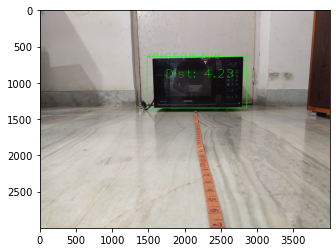

In [3]:
# image_filename = 'name.png' # replace with your own image
# encoded_image = base64.b64encode(open(image_filename, 'rb').read())
###########################################==========================


#====
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model = 'frozen_inference_graph.pb'
model = cv2.dnn_DetectionModel(frozen_model, config_file)
classNames = []
classFile = 'coco.names'
with open(classFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')
    
print(classNames)
model.setInputSize(320, 320)
model.setInputScale(1.0 / 127.5)
model.setInputMean((127.5, 127.5, 127.5))
model.setInputSwapRB(True)


#====
server = Flask(__name__)

app = dash.Dash(external_stylesheets = [dbc.themes.BOOTSTRAP], server=server)
app.layout = html.Div(
    children = [
        html.H3("Dashboard"),
        html.Div([
            dbc.Button("Image", id = "photo-btn"),
            html.Div([dbc.Button("Video", id = "video-btn",)], hidden =True),
        ],style = {"height":"40px"}),
        html.Div(id = "photo-div",hidden = False,style = {'float':'left','height':'100%','width':'100%','padding':'5px'},
                children = [
                    dbc.Card(children = [
                        dbc.CardHeader("Upload Your Image Here"),
                        dbc.CardBody(children = [
                            html.H3("Calculate Camera Distance For Image"),
                            dcc.Upload(
                            id='upload-image',
                            children=html.Div([
                                'Drag and Drop or ',
                                html.A('Select Files')
                            ]),
                            style={
                                'width': '100%',
                                'height': '60px',
                                'lineHeight': '60px',
                                'borderWidth': '1px',
                                'borderStyle': 'dashed',
                                'borderRadius': '5px',
                                'textAlign': 'center',
                                'margin': '10px'
                            },
                            # Allow multiple files to be uploaded
                            multiple=True),
                            html.Div(id = 'output-image-upload',style = {"width":"50%",'float':'left', "padding":"10px"}),
                            html.Div(id = "result-image-upload",style = {"width":"50%",'float':'left', "padding":"10px"},
                                    children = [
                                        html.Img(id = "image-ouput-v1",
                                                 #src=app.get_asset_url('name - Copy.png'), 
                                                 style = {"width":"100%"})
                                    ])
                        ])
                    ])
                ]),
        html.Div(id = "video-div",hidden = True,style = {'float':'left','height':'100%','width':'100%','padding':'5px'},
                children = [
                    dbc.Card(children = [
                        dbc.CardHeader("Video"),
                        dbc.CardBody(children = [
                            html.H3("Calculate Camera Distance For Video"),
                            dcc.Upload(
                            id='upload-video',
                            children=html.Div([
                                'Drag and Drop or ',
                                html.A('Select Files')
                            ]),
                            style={
                                'width': '100%',
                                'height': '60px',
                                'lineHeight': '60px',
                                'borderWidth': '1px',
                                'borderStyle': 'dashed',
                                'borderRadius': '5px',
                                'textAlign': 'center',
                                'margin': '10px'
                            },
                            # Allow multiple files to be uploaded
                            multiple=True),
                            html.Div(id = 'output-video-upload',style = {"width":"50%",'float':'left', "padding":"10px"}),
                            html.Div(id = "result-video-upload",style = {"width":"50%",'float':'left', "padding":"10px"},
                                    children = [
                                        html.Video(id = "video-ouput-v1",autoPlay=True,
                                                 #src=app.get_asset_url('name - Copy.png'), 
                                                 style = {"width":"100%"})
                                    ])
                        ])
                    ])
                ])
    ],
    style={'height':'50vh'}
)

@app.server.route('/static/<path:path>')
def serve_static(path):
    root_dir = os.getcwd()
    return flask.send_from_directory(os.path.join(root_dir, 'static'), path)
@app.callback([Output("video-div","hidden"), Output("photo-div","hidden")],
             [Input("photo-btn","n_clicks"), Input("video-btn","n_clicks")])
def update_divison_hidden(n1, n2):
    if n1 or n2:
        ctx = dash.callback_context
        button_id = ctx.triggered[0]['prop_id'].split('.')[0] 
        if button_id=="photo-btn":
            return True, False
        else:
            return False, True
        return
    else:
        raise dash.exceptions.PreventUpdate()

# dash callbacks
@app.callback([Output('output-image-upload', 'children'), Output("image-ouput-v1","src")],
              Input('upload-image', 'contents'),
              State('upload-image', 'filename'),
              State('upload-image', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        df= pd.read_excel("Object_df2.xlsx")
        children = [parse_contents(c, n, d) for c, n, d in zip(list_of_contents, list_of_names, list_of_dates)]
        #img = Image.open(list_of_names[0])
        img = cv2.imread(list_of_names[0])
        img = np.asarray(img)
        #print(img)
        ClassIndex, confidece, bbox = model.detect(img, confThreshold=0.7)
        #font
        font_scale= 12
        font = cv2.FONT_HERSHEY_PLAIN

        #area calculation
        area=(bbox[0][2]*bbox[0][3])
        #area=str(area)

        #interpolation
        x=df[df["Class_index"]==ClassIndex[0]].index.values
        x=x[0]
        print(x)

        global lst 
        lst = []
        for i in range(2,7):
            y=df.iat[x,i]
            lst.append(y)

        global lst1
        lst1=[2.0,2.5,3.0,3.5,4.0]

        y_interp = scipy.interpolate.interp1d(lst, lst1,fill_value="extrapolate")
        result=np.round(y_interp(area),2)

        result=str(result)
        area=abs(area)
        area=str(area)

        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidece.flatten(), bbox):
            #ev2. rectangle(frome, (x, y), (x+N, yrh), (255, e, 0), 2)
            #cv2. put Text( ing, text, (text_offset_x, textoffset_y), font, fontScale-font scale, color-(0, e, e), thickness-1)
            cv2.rectangle(img, boxes, color = (0,255,0), thickness = 5)
            cv2.putText(img,classNames[ClassInd-1],(boxes[0]+10, boxes[1]+40), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)
            #cv2.putText(img,area,(boxes[0]+250, boxes[1]+300), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)
            cv2.putText(img,("Dist: {} ft".format(result)),(boxes[0]+250, boxes[1]+300), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)


        img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        matplotlib.image.imsave('name.png', img_rgb)
        image_filename = 'name.png' # replace with your own image
        encoded_image = base64.b64encode(open(image_filename, 'rb').read())
        output_image_src = "http://localhost:8888/notebooks/Desktop/object_detection_capstone/name.png"
        #return children, output_image_src# 'data:image/png;base64,{}'.format(encoded_image)
        return children, 'data:image/png;base64,{}'.format(encoded_image.decode())
    else:
        raise dash.exceptions.PreventUpdate()
# dash callbacks
@app.callback([Output('output-video-upload', 'children'), Output("video-ouput-v1","src")],
              Input('upload-video', 'contents'),
              State('upload-video', 'filename'),
              State('upload-video', 'last_modified'))
def upload_and_show_video(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        try:
            df= pd.read_excel("Object_df2_vid.xlsx")
            children = [parse_video_contents(c, n, d) for c, n, d in zip(list_of_contents, list_of_names, list_of_dates)]
            print(list_of_names[0])
            cap= cv2.VideoCapture(list_of_names[0])
            print(cap)
            font_scale=3
            font= cv2.FONT_HERSHEY_PLAIN
            frame_width = 640
            frame_height = 480
            #df= pd.read_excel("Object_df2.xlsx")

            #out = cv2.VideoWriter(os.path.join(os.getcwd(),'static\output_gen.avi'),cv2.VideoWriter_fourcc(*'MJPG'), 10,(frame_width,frame_height))
            #out = cv2.VideoWriter('output_gen.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10,(frame_width,frame_height))
            out = cv2.VideoWriter(os.path.join(os.getcwd(),'static\output_gen.mp4'),cv2.VideoWriter_fourcc(*'X264'), 20,(frame_width,frame_height))
            while True:
                ret,frame=cap.read()

                ClassIndex, confidece, bbox=model.detect(frame, confThreshold=0.5)
                print(ClassIndex)

                x=df[df["Class_index"]==ClassIndex[0]].index.values
                x=x[0]
                print(x)

                global lst 
                lst = []
                for i in range(2,7):
                    y=df.iat[x,i]
                    lst.append(y)

                global lst1
                lst1=[2.0,2.5,3.0,3.5,4.0]

                if (len(ClassIndex)!= 0):
                    for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidece.flatten(), bbox):
                        #area
                        print(boxes)
                        area=(boxes[2]*boxes[3])
                        print(area)
                        #interpolation
                        y_interp = scipy.interpolate.interp1d(lst, lst1,fill_value="extrapolate")
                        result=(y_interp(area))

                        result=str(result)
                        area=str(area)


                        if (ClassInd<=80):
                            cv2.rectangle(frame, boxes, (255, 0, 0), 2)
                            cv2.putText(frame,classNames[ClassInd-1],(boxes[0]+10, boxes[1]+40), font, fontScale=font_scale,color=(0, 255, 0), thickness=8)
                            cv2.putText(frame,area,(boxes[0]+50, boxes[1]+100), font, fontScale=font_scale,color=(0, 255, 0), thickness=8)
                            cv2.putText(frame,result,(boxes[0]+80, boxes[1]+150), font, fontScale=font_scale,color=(0, 255, 0), thickness=8)
                out.write(frame)
                #cv2. imshow("Object Detection", frame)

                if cv2.waitKey(2)& 0XFF == ord('q'):
                    break

            cap.release()
            out.release()
            cv2.destroyAllWindows()
        except:
            print("Video Saved completed")
        
        return children, '/static/output_gen.mp4'
    else:
        raise dash.exceptions.PreventUpdate()
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader = False)

In [2]:
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model = 'frozen_inference_graph.pb'
model = cv2.dnn_DetectionModel(frozen_model, config_file)
classNames = []
classFile = 'coco.names'
with open(classFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')
    
print(classNames)
model.setInputSize(320, 320)
model.setInputScale(1.0 / 127.5)
model.setInputMean((127.5, 127.5, 127.5))
model.setInputSwapRB(True)

df= pd.read_excel("Object_df2.xlsx")

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


In [8]:
cap= cv2.VideoCapture("mv_3_video.mp4")

#Check if the video is opened correctly
if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")
print(cap)
font_scale=3
font= cv2.FONT_HERSHEY_PLAIN
frame_width = 640
frame_height = 480
#df= pd.read_excel("Object_df2.xlsx")

#out = cv2.VideoWriter(os.path.join(os.getcwd(),'static\output_gen.avi'),cv2.VideoWriter_fourcc(*'MJPG'), 10,(frame_width,frame_height))
#out = cv2.VideoWriter('output_gen.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10,(frame_width,frame_height))
out = cv2.VideoWriter(os.path.join(os.getcwd(),'static\output_gen4.mp4'),cv2.VideoWriter_fourcc(*'H264'), 
                      20,(frame_width,frame_height))
while True:
    ret,frame=cap.read()

    ClassIndex, confidece, bbox=model.detect(frame, confThreshold=0.5)
    print(ClassIndex)
    
    x=df[df["Class_index"]==ClassIndex[0]].index.values
    x=x[0]
    print(x)
    
    global lst 
    lst = []
    for i in range(2,7):
        y=df.iat[x,i]
        lst.append(y)
    
    global lst1
    lst1=[2.0,2.5,3.0,3.5,4.0]
    
    if (len(ClassIndex)!= 0):
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidece.flatten(), bbox):
            #area
            print(boxes)
            area=(boxes[2]*boxes[3])
            print(area)
            #interpolation
            y_interp = scipy.interpolate.interp1d(lst, lst1,fill_value="extrapolate")
            result=(y_interp(area))
            
            result=str(result)
            area=str(area)
            
            
            if (ClassInd<=80):
                cv2.rectangle(frame, boxes, (255, 0, 0), 2)
                cv2.putText(frame,classNames[ClassInd-1],(boxes[0]+10, boxes[1]+40), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)
                cv2.putText(frame,area,(boxes[0]+50, boxes[1]+100), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)
                cv2.putText(frame,result,(boxes[0]+80, boxes[1]+150), font, fontScale=font_scale,color=(0, 255, 0), thickness=3)
    out.write(frame)
    #cv2. imshow("Object Detection", frame)
    
    if cv2.waitKey(2)& 0XFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

<VideoCapture 000001E6ACF46DF0>
[78]
6
[344 143 568 319]
181192
[78]
6
[346 142 568 321]
182328
[78]
6
[342 142 574 320]
183680
[78]
6
[342 141 572 321]
183612
[78]
6
[343 142 571 320]
182720
[78]
6
[340 143 581 319]
185339
[78]
6
[339 142 581 321]
186501
[78]
6
[340 143 578 318]
183804
[78]
6
[340 142 577 320]
184640
[78]
6
[339 143 575 319]
183425
[78]
6
[340 143 580 320]
185600
[78]
6
[356 141 563 320]
180160
[78]
6
[346 142 571 321]
183291
[78]
6
[345 141 572 321]
183612
[78]
6
[345 142 575 320]
184000
[78]
6
[357 141 561 317]
177837
[78]
6
[354 141 567 316]
179172
[78]
6
[341 140 580 321]
186180
[78]
6
[342 140 578 322]
186116
[78]
6
[360 140 560 319]
178640
[78]
6
[343 140 576 319]
183744
[78]
6
[356 139 564 315]
177660
[78]
6
[342 139 582 324]
188568
[78]
6
[342 139 582 323]
187986
[78]
6
[341 140 585 324]
189540
[78]
6
[342 140 583 325]
189475
[78]
6
[343 142 586 325]
190450
[78]
6
[345 141 583 327]
190641
[78]
6
[340 141 587 326]
191362
[78]
6
[349 140 577 324]
186948
[78]
6
[

[78]
6
[159  62 917 491]
450247
[78]
6
[158  60 919 491]
451229
[78]
6
[154  59 931 492]
458052
[78]
6
[163  54 921 502]
462342
[78]
6
[158  55 923 497]
458731
[78]
6
[160  55 924 498]
460152
[78]
6
[171  54 919 503]
462257
[78]
6
[169  54 919 500]
459500
[78]
6
[170  53 916 497]
455252
[78]
6
[173  52 916 498]
456168
[78]
6
[173  50 917 501]
459417
[78]
6
[172  49 921 503]
463263
[78]
6
[170  49 922 502]
462844
[78]
6
[168  48 925 503]
465275
[78]
6
[168  48 927 504]
467208
[78]
6
[168  49 924 504]
465696
[78]
6
[166  48 925 505]
467125
[78]
6
[166  48 925 506]
468050
[78]
6
[161  44 933 510]
475830
[78]
6
[159  45 937 510]
477870
[78]
6
[164  47 932 511]
476252
[78]
6
[166  47 932 510]
475320
[78]
6
[163  48 937 510]
477870
[78]
6
[165  45 936 520]
486720
[78]
6
[160  49 939 511]
479829
[78]
6
[170  50 930 518]
481740
[78]
6
[174  54 924 518]
478632
[78]
6
[172  57 926 519]
480594
[78]
6
[178  58 915 519]
474885
[78]
6
[178  62 918 517]
474606
[78]
6
[178  63 914 515]
470710
[78]
6
[

[78]
6
[302  57 573 320]
183360
[78]
6
[302  51 576 325]
187200
[78]
6
[298  44 579 329]
190491
[78]
6
[298  43 581 326]
189406


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
os.path.join(os.getcwd(),'static\output_gen.avi')

In [5]:
import ffmpeg

ModuleNotFoundError: No module named 'ffmpeg'